In [2]:
# Imports 
# native
import os
import re
from collections import Counter
from collections import defaultdict
import random
from itertools import chain

# external
import requests
import numpy as np
import seaborn as sns
### NEW import
import modin.pandas as pd
from modin.config import Engine
Engine.put("ray")
os.environ["MODIN_CPUS"] = "3"


In [10]:
icity_df = pd.read_csv('/home/hugo/projects/salmonella-bacterial-immunity/results/icity.main.tsv', sep='\t')[[
    'seeds',
    'members_names',
    'members_count',
    'members_close_to_baits',
    'icity', 'diversity_score',
    'diversity_of_close_systems',
    'mean_closest_bait_distance',
    'std_closest_bait_distance',
    'cv_closest_bait_distance'
]]
icity_df.head()

,seeds,members_names,members_count,members_close_to_baits,icity,diversity_score,diversity_of_close_systems,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
0,ELEBACFE_01409,"apt:99.82%,apt_2:0.02%,apt_1:0.16%,apt_3:0.01%",16288,5,0.000307,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
1,GEPOOPDK_00969,"dnaX:99.96%,dnaX_1:0.03%,dnaX_2:0.01%,dnaX_3:0...",15988,5,0.000313,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
2,OPMEBHBH_00282,"ybaB:99.96%,ybaB_1:0.02%,ybaB_2:0.02%,ybaB_3:0...",16281,5,0.000307,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
3,LEDEBBBD_02850,"htpG_1:9.17%,htpG_2:1.62%,htpG:89.2%,htpG_3:0....",16253,5,0.000308,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
4,HLLNPLAH_02376,"adk:99.86%,adk_1:0.09%,adk_2:0.03%,adk_3:0.01%...",16284,1,0.000061,0.000002,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN


In [14]:
before_filtering = {'seeds': 264793, 'proteins': 74326142,}

In [15]:
after_filtering = {'seeds': icity_df.seeds.shape[0], 'proteins': icity_df.members_count.sum()}

In [16]:
after_filtering

{'seeds': 20817, 'proteins': 25741130}

In [48]:
fig1_df = pd.DataFrame.from_dict({
    'status'  : ['before', 'before', 'after',  'after'],
    'count': [74326142, 264793, 25741130, 20817],
    'type'    : ['protein', 'seed', 'protein', 'seed'],
})
fig1_df.head()

,status,count,type
0,before,74326142,protein
1,before,264793,seed
2,after,25741130,protein
3,after,20817,seed


Text(0.5, 0.98, 'Fig1: Filter out seeds that dont have a single members close to a bait (some seeds are a bait)')

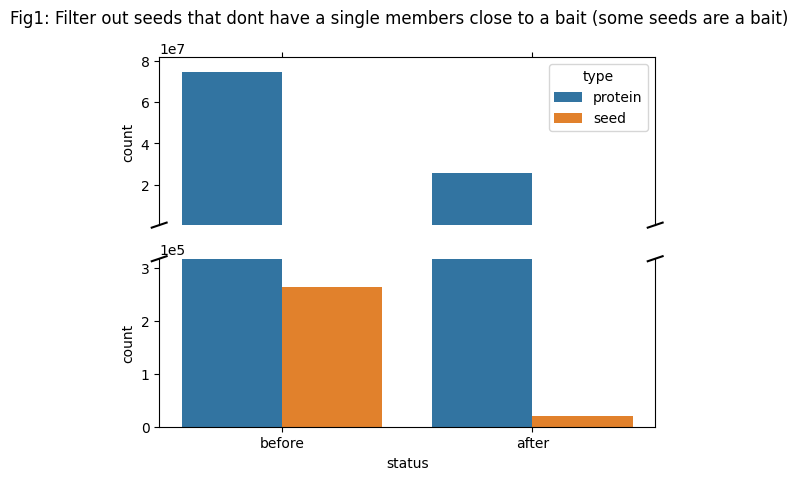

In [59]:
# create a 2 by 1 grid 
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# Create two plots (top and bottom)
sns.barplot(data=fig1_df, x='status', y='count', hue='type', ax=ax)
sns.barplot(data=fig1_df, x='status', y='count', hue='type', ax=ax2)
ax2.legend_.remove()

# Set sci notation to y
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

# Set limit to top and bottom
bottom_limit = fig1_df.query('type == "seed"')['count'].max() * 1.2
top_limit = fig1_df['count'].max() * 1.1
ax.set_ylim(bottom_limit, top_limit)  # outliers only
ax2.set_ylim(0, bottom_limit)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.set_xlabel('') # remove top xlabel

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set title 
f.suptitle("Fig1: Filter out seeds that dont have a single members close to a bait (some seeds are a bait)")



 #, col='status' , kind='bar', aspect=.7)

<AxesSubplot:>

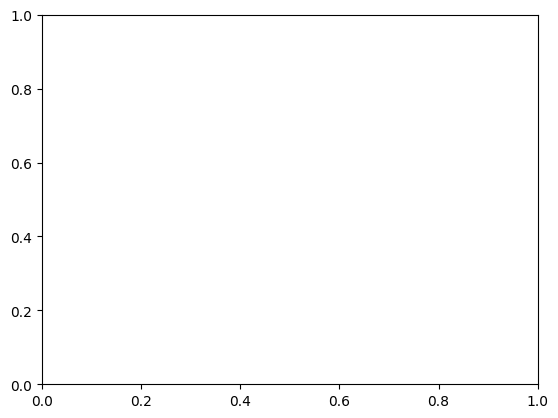

In [70]:
sns.histplot(x=icity_df.query('diversity_of_close_systems == "NA"').icity)

In [82]:
len(icity_df.diversity_of_close_systems.unique())

8153

In [91]:
icity_df.sort_values(['icity', 'diversity_score'], ascending=False).query('icity < 1').head(20)

,seeds,members_names,members_count,members_close_to_baits,icity,diversity_score,diversity_of_close_systems,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
767,OIICPPNC_01267,"casC:99.85%,casC_1:0.08%,casC_2:0.07%",10120,10119,0.999901,0.199382,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
764,BPPBCHKB_01625,"ygbT:99.73%,ygbT_1:0.14%,ygbT_2:0.13%",9903,9902,0.999899,0.196177,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
766,NBJKFGOO_02445,Hypothetical Protein:100.0%,10234,10232,0.999805,0.201781,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
1814,IJLIHHGB_01195,"Hypothetical Protein:99.87%,casA:0.13%",4497,4496,0.999778,0.088684,"{'padloc:name=Cas5e,system=cas_type_I-E;defens...",NaN,NaN,NaN
768,LAGNHMEK_02052,Hypothetical Protein:100.0%,8589,8587,0.999767,0.168928,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
2180,ALDDAGCD_04218,Hypothetical Protein:100.0%,3982,3981,0.999749,0.076171,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
2181,FLEIADLP_00974,"lon_3:24.1%,lon_2:41.71%,lon_1:33.97%,lon_5:0....",3515,3514,0.999716,0.075385,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
2184,MIHNGDJK_00043,Hypothetical Protein:100.0%,3152,3151,0.999683,0.068916,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
765,CPHHPHLB_05241,"casE:99.37%,cse3:0.49%,Hypothetical Protein:0....",10130,10126,0.999605,0.199449,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
6600,OEDBNFEP_00945,Hypothetical Protein:100.0%,2442,2441,0.999590,0.018166,"{'padloc:name=DruE3,system=druantia_type_III;d...",NaN,NaN,NaN


# Network

In [3]:
all_cds_location = '../../icity_input/all_cds.tsv'
dfs_prediction = '../../icity_input/dfs_prediction.sample.tsv'
cluster_file = '../../icity_input/mmseqs_cluster.tsv'

In [3]:
# Functions 
def get_sequential_groups(vals: iter) -> list:
    """ This functions take as input a SORTED iterables with UNIQUE values
        and returns a list with all groups that are sequential labaled by a
        interger index.
        Ex: 
        $ get_sequential_groups([1528, 1529, 1530, 1531, 1559, 1560, 1561, 1562, 1565, 1566])
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3]
    """
    groups_index = 1
    groups = []
    stack = []
    for i in vals:
        
        if not stack:
            stack.append(i)
            groups.append(groups_index)
            continue
            
        if i == stack[-1] + 1:
            stack.append(i)
            groups.append(groups_index)
            
        else:
            groups_index += 1
            groups.append(groups_index)
            stack = [i]
            
    return groups


def check_neighborhood(all_items: iter, range_to_check: int = 10) -> list:
    if not any(all_items):
        for i in all_items:
            yield None
        return
    
    all_indexes = tuple(enumerate(all_items))
    baits_location = sorted(set(i for i, x in all_indexes if x))
    
    for indx, _ in all_indexes:
        
        if indx in baits_location:
            yield 'is_bait'
            continue
           
        if min(map(lambda x: abs(indx - x), baits_location)) <= range_to_check:
            yield 'is_close'
            continue
        
        yield None


def get_distance_from_baits(df) -> tuple:
    bait_coords = set(df.query('bait_assign == "is_bait"').start.values.tolist())
    
    for start_coord, bait_assign in df.values.tolist():
        if not bait_assign:
            yield None
            continue
            
        if start_coord in bait_coords:
            yield 0
            continue
        
        yield min(map(lambda x: abs(start_coord - x), bait_coords))

def get_name_percentage(info_list):
    total_info = len(info_list)
    name_counts = Counter(re.findall('(?<=Name\=).+?(?=\;)' ,';'.join(info_list)))
    total_count = sum(name_counts.values())
    
    results = []
    for name, count in name_counts.items():
        results.append('{}={}%'.format(name, round((count/total_info)*100, 2)))
    
    if not total_count == total_info:
        results.append('Hypothetical protein={}%'.format(round(((total_info - total_count)/total_info)*100, 2)))
    
    return ';'.join(results)


def get_name_systems(info_list):
    name_counts = Counter(re.findall('(?<=system\=).+?(?=\;)', ';'.join(info_list)))
    
    results = []
    
    if not name_counts:
        return None
    
    for name, count in name_counts.items():
        results.append('{}'.format(name))
    
    return ';'.join(results)


def get_edges(topology: iter):
    for indx, cluster_id in enumerate(topology):
        try:
            yield (cluster_id, topology[indx + 1])
        except IndexError:
            pass
        

def assign_loci_id(bait_assign_iter):
    current_loci_index = 1
    is_inside_loci = False
    
    for description in bait_assign_iter:
        
        if not description and is_inside_loci:
            current_loci_index += 1
        
        if not description:
            is_inside_loci = False
            yield None
            continue
        
        is_inside_loci = True
        yield 'loci_{}'.format(str(current_loci_index))

        
def most_common_name(annotations: iter):
    for annotation in annotations:
        if not annotation:
            yield 'NA'
            continue
        
        yield sorted(map(lambda x: x.split('='), annotation.split(';')), key = lambda x: float(x[1].replace('%', '')), reverse=True)[0][0]
        
    

In [4]:
cds_df = (pd.read_csv(all_cds_location, header=None, sep='\t')
          .rename(columns = dict(zip(range(6), ['locus_tag', 'contig_id', 'start', 'end', 'strand', 'info'])))
          .assign(contig_index = lambda df: df.contig_id.apply(lambda contig_id: int(contig_id.split('_')[1])))
          .sort_values(['contig_id', 'contig_index', 'start'])
          .drop('contig_index', axis=1)
          .assign(csd_lenght = lambda df: df.end - df.start )
          .merge(
              pd.read_csv(dfs_prediction, header=None, sep=' ').rename(columns={0: 'locus_tag', 1: 'dfs_prediction'}),
              on=['locus_tag'],
              how='left'
          )
          .merge(
              pd.read_csv(cluster_file, header=None, sep='\t').rename(columns={0: 'seeds', 1: 'locus_tag'}),
              on=['locus_tag'],
              how='inner'
          )
          .groupby('contig_id', as_index=False)
          .apply(lambda gdf: (gdf
                              .assign(bait_assign = lambda x: tuple(check_neighborhood(x.dfs_prediction.fillna(0).values)))
                              .assign(distance_to_bait = lambda x: tuple(get_distance_from_baits(x.loc[:, ['start', 'bait_assign']])))
                              .assign(loci_id = lambda x: tuple(assign_loci_id(x.bait_assign)))
                             ))
         )

cds_df.head()

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


,locus_tag,contig_id,start,end,strand,info,csd_lenght,dfs_prediction,seeds,bait_assign,distance_to_bait,loci_id
0,KDHGNBDG_00001,1395103.4_1,81,626,-,ID=KDHGNBDG_00001;eC_number=1.3.5.3;Name=hemG;...,545,NaN,IOMDNFNB_03950,None,None,None
1,KDHGNBDG_00002,1395103.4_1,638,2089,-,ID=KDHGNBDG_00002;Name=trkH;db_xref=COG:COG016...,1451,NaN,IOMDNFNB_03949,None,None,None
2,KDHGNBDG_00003,1395103.4_1,2128,2742,-,ID=KDHGNBDG_00003;Name=yigZ;db_xref=COG:COG173...,614,NaN,GBGIPKHN_04153,None,None,None
3,KDHGNBDG_00004,1395103.4_1,2742,4073,-,ID=KDHGNBDG_00004;eC_number=3.4.13.9;Name=pepQ...,1331,NaN,IOMDNFNB_03947,None,None,None
4,KDHGNBDG_00005,1395103.4_1,4264,6453,+,ID=KDHGNBDG_00005;Name=fadB;db_xref=COG:COG102...,2189,NaN,IOMDNFNB_03946,None,None,None


In [224]:
seeds_df = (cds_df.groupby('seeds')
            .agg({
                'seeds'           : 'count',
                'bait_assign'     : [
                    lambda x: x.where(lambda x: x != None).dropna().shape[0],
                    lambda x: x.where(lambda x: x == 'is_bait').dropna().shape[0],
                ],
                'locus_tag'       : lambda x: ','.join(x.values.tolist()),
                'distance_to_bait': 'mean',
                'info'            : lambda x: get_name_percentage(x.values),
                'dfs_prediction'  : lambda x: get_name_systems(x.fillna('NA')),
                'csd_lenght'      : 'mean',
            })
            .droplevel(0, axis=1))

seeds_df.columns = ['members_count', 'members_close_to_baits', 'is_bait_count', 'locus_tags', 'mean_distance_to_bait', 'members_names', 'dfs_names', 'cds_lenght_mean']


seeds_df = (seeds_df
            .query('members_close_to_baits > 0')
            .assign(icity = lambda df: df.members_close_to_baits / df.members_count)
            .sort_values('mean_distance_to_bait', ascending=False)
            [['members_count', 'icity', 'mean_distance_to_bait', 'members_close_to_baits', 'is_bait_count', 'locus_tags', 'members_names', 'dfs_names', 'cds_lenght_mean']]
            .assign(is_bait_perc = lambda df: df.is_bait_count / df.members_count)
            [['members_count', 'icity', 'mean_distance_to_bait', 'members_close_to_baits', 'locus_tags', 'members_names', 'is_bait_count', 'is_bait_perc', 'dfs_names', 'cds_lenght_mean']]
            .reset_index()
           )


dfs_dict = (cds_df
            .groupby(['contig_id', 'loci_id'])
            .apply(
                lambda df: df.assign(group_systems = tuple(assign_loci_id(df.fillna(0).dfs_prediction)))
            )
            .query('group_systems.notna()')
            .groupby(['contig_id', 'loci_id', 'group_systems'])
            .agg({'seeds': lambda x: sorted(tuple(x.values))})
            .droplevel('group_systems')
            .reset_index()
            .groupby(['contig_id', 'loci_id'])
            .agg({'seeds': lambda x: x.values.tolist()})).seeds.to_dict()

dfs_count = len(set(map(tuple, chain.from_iterable(dfs_dict.values()))))

seeds_df = seeds_df.merge(
    (cds_df.loc[:,['seeds', 'contig_id', 'loci_id']]
     .query('loci_id.notna()')
     .drop_duplicates()
     .assign(tup_query = lambda df: tuple(map(lambda x: tuple(x), df[['contig_id', 'loci_id']].values.tolist())))
     .assign(diversity_count = lambda df: df.tup_query.apply(lambda x:  tuple(map(lambda y: tuple(y), dfs_dict.get(x, None))) ))
     .groupby('seeds')
     .agg({'diversity_count': lambda x: len(set(chain.from_iterable(x.values)))})
     .assign(diversity_score = lambda df: df.diversity_count / dfs_count)),
    on=['seeds'],
    how='inner'
)[['seeds', 'members_count', 'icity', 'diversity_score', 'mean_distance_to_bait', 'members_close_to_baits', 'locus_tags', 'members_names', 'is_bait_count', 'is_bait_perc', 'dfs_names', 'cds_lenght_mean']]


seeds_df.head()

,seeds,members_count,icity,diversity_score,mean_distance_to_bait,members_close_to_baits,locus_tags,members_names,is_bait_count,is_bait_perc,dfs_names,cds_lenght_mean
0,IOMDNFNB_02782,10,0.100000,0.024390,25864.0,1,"KDHGNBDG_03097,ACCAFLOF_04505,HDGJAOOK_04407,B...",ratA=100.0%,0,0.0,None,437.000000
1,IOMDNFNB_02783,10,0.100000,0.024390,25193.0,1,"KDHGNBDG_03098,ACCAFLOF_04506,HDGJAOOK_04406,B...",smpB=100.0%,0,0.0,None,527.000000
2,MPAOKENP_02509,9,0.222222,0.073171,18952.5,2,"KDHGNBDG_03099,ACCAFLOF_04507,HDGJAOOK_04432,B...",Hypothetical protein=100.0%,0,0.0,None,11410.333333
3,BKDLJELO_03110,9,0.111111,0.024390,18014.0,1,"ACCAFLOF_00753,HDGJAOOK_02664,BKDLJELO_03110,G...",yeeO=100.0%,0,0.0,None,1431.000000
4,HOHECEAN_01031,8,0.125000,0.024390,17780.0,1,"ACCAFLOF_00019,HDGJAOOK_02829,BKDLJELO_02986,G...",pipB2=100.0%,0,0.0,None,1052.000000


In [9]:
seeds_df = pd.read_csv('/home/hugo/projects/salmonella-bacterial-immunity/icity_input/seeds_df.tsv.gz', sep='\t').head()

# START HERE

In [6]:
# Network variables
max_diameter_size = 230
min_diameter_size = 10

max_edge_size = 60
min_edge_size = 1

max_border_size = 60
min_border_size = 1


min_bait_count_to_be_bait = .2

default_color = '#d4ecff'


In [12]:
max_members_count = seeds_df.members_count.max()

color_pallet = defaultdict(lambda: "#%06x" % random.randint(0, 0xFFFFFF))

nodes = (seeds_df
         .drop('locus_tags', axis=1)
         .rename(columns={'seeds': 'id'})
         .assign(node_size = lambda df: df.members_count.apply(lambda x: int((max_diameter_size * x)/max_members_count)))
         .assign(node_shape = lambda df: df.is_bait_perc.apply(lambda x: 'TRIANGLE' if x > min_bait_count_to_be_bait else 'ELLIPSE'))
         .assign(dfs_label = lambda df: df.dfs_names.apply(lambda x: None if not x or not isinstance(x, str) else x.upper().split(';')[-1].split('_')[0]))
         .assign(node_color = lambda df: df.dfs_label.apply(lambda x: default_color if not x else color_pallet[x]))
         .assign(node_color = lambda df: tuple(map(lambda x: default_color if x == 'ELLIPSE' else x[1], df[['node_shape', 'node_color']].values.tolist())))
         .assign(border_size = lambda df: df.icity.apply(lambda x: max(min_border_size, int(x * max_border_size))))
         .assign(border_size = lambda df: tuple(map(lambda x: min_border_size if x[0] == 'TRIANGLE' else x[1], df[['node_shape', 'border_size']].values.tolist())))
        )

nodes.head()

,id,members_count,icity,diversity_score,mean_distance_to_bait,members_close_to_baits,members_names,is_bait_count,is_bait_perc,dfs_names,cds_lenght_mean,node_size,node_shape,dfs_label,node_color,border_size
0,LBGIAHIP_02704,16180,0.000062,0.000459,29810.0,1,yfgJ=99.96%;yfgJ_2=0.01%;yfgJ_1=0.02%,0,0.0,NaN,220.986465,230,ELLIPSE,None,#d4ecff,1
1,KMNDBCDK_03119,11789,0.000085,0.000459,29242.0,1,eae=0.02%;Hypothetical protein=99.98%,0,0.0,NaN,2191.674782,167,ELLIPSE,None,#d4ecff,1
2,MAKOHINP_02374,1913,0.000523,0.000459,26992.0,1,Hypothetical protein=100.0%,0,0.0,NaN,965.664924,27,ELLIPSE,None,#d4ecff,1
3,DCEJALHG_01880,921,0.001086,0.000459,26426.0,1,dhbE=100.0%,0,0.0,NaN,1577.029316,13,ELLIPSE,None,#d4ecff,1
4,AKFFODHP_04157,908,0.002203,0.000919,26241.0,2,Hypothetical protein=100.0%,0,0.0,NaN,1099.914097,12,ELLIPSE,None,#d4ecff,1


In [ ]:
edges = (cds_df
         .loc[:,['contig_id','seeds', 'bait_assign']]
         .assign(loci_id = lambda df: tuple(assign_loci_id(df.bait_assign)))
         .query('bait_assign.notna()')
         .groupby(['contig_id', 'loci_id'])
         .agg({
             'seeds' : lambda series: tuple(get_edges(series.values))
         })
         .explode('seeds')
         .reset_index()
         .loc[:,'seeds']
         .apply(lambda edge: sorted(edge, key=lambda seed_id: int(seed_id.split('_')[1])))
         .to_frame()
         .assign(source = lambda df: df.seeds.apply(lambda x: x[0]))
         .assign(target = lambda df: df.seeds.apply(lambda x: x[1]))
         .drop('seeds', axis=1)
         .groupby(['source', 'target'], as_index=False)
         .size()
         .sort_values('size', ascending=False)
         .rename(columns={'size': 'weight'})
         .reset_index(drop=True))

max_edge_count = edges.weight.max()



edges = (edges
         .assign(edge_size = lambda df: df.weight.apply(lambda x: max(min_edge_size, int((max_edge_size * x)/max_edge_count)))))


edges.head()

# Cytoscape

In [7]:
nodes_fname = '/home/hugo/projects/salmonella-bacterial-immunity/icity_input/nodes_df.tsv'
edges_fname = '/home/hugo/projects/salmonella-bacterial-immunity/icity_input/edges_df.tsv'

In [8]:
nodes = (pd.read_csv(nodes_fname, sep='\t')
         .assign(node_color = lambda df: tuple(map(lambda x: default_color if x[0] == 'ELLIPSE' else x[1] , df[['node_shape', 'node_color']].values)))
         .assign(node_size = lambda df: df.node_size.apply(lambda x: max(min_diameter_size, x)))
        )
# nodes = (nodes
#          .query('(members_count >= 20 & icity >= 0.6 & cds_lenght_mean >= 300)')
#          )
nodes.head()

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



,id,members_count,icity,diversity_score,mean_distance_to_bait,members_close_to_baits,members_names,is_bait_count,is_bait_perc,dfs_names,cds_lenght_mean,node_size,node_shape,dfs_label,node_color,border_size
108,ONMBJOCA_01516,16235,0.613736,0.091410,14790.134986,9964,mazG=99.98%;mazG_2=0.01%;mazG_1=0.01%,4,0.000246,cas_type_I-E;Cas,799.842747,115,ELLIPSE,CAS,#d4ecff,36
178,AOHLAGHF_05336,229,0.908297,0.003215,13584.307692,208,ompX_2=28.82%;ompX_1=70.74%;ompX_3=0.44%,0,0.000000,NaN,332.117904,10,ELLIPSE,NaN,#d4ecff,54
193,DJBBIFAA_02730,9975,0.848421,0.006431,13424.751861,8463,ail_3=43.19%;ail_2=29.77%;ail_1=22.29%;ail_5=0...,0,0.000000,NaN,524.004511,70,ELLIPSE,NaN,#d4ecff,50
202,DPINHLID_00131,16286,0.747575,0.113918,13349.425791,12175,pyrG=99.88%;pyrG_2=0.03%;pyrG_1=0.09%,5,0.000307,cas_type_I-E;Cas,1637.004237,115,ELLIPSE,CAS,#d4ecff,44
236,NGDGIGNN_01020,49,0.836735,0.000459,13075.560976,41,Hypothetical protein=100.0%,0,0.000000,NaN,464.000000,10,ELLIPSE,NaN,#d4ecff,50


In [9]:
edges = pd.read_csv(edges_fname, sep='\t')
edges = edges.query('source in @nodes.id and target in @nodes.id and source != target')
edges.head()

,source,target,weight,edge_size
1,OBMGFKCN_01195,OEDBNFEP_02507,15104,59
2,CAADGEIO_02721,AHDJACDG_03207,15071,59
5,LNIMPGBG_00571,PBEJCPJL_03468,14847,58
8,AGMDNHOK_03377,PBEJCPJL_03468,14716,58
9,LCKPLMNB_00175,KOJBJDKH_04028,14440,57


## Cytoscape

Outside jupyter open the Cytoscape GUI client


In [10]:
# START CYTOSCAPE CLIENT OUTSIDE JUPYTER 

In [11]:
# With the Cytoscape client open, run the following lines
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

Requirement already satisfied: py4cytoscape in /home/hugo/.local/lib/python3.10/site-packages (1.5.0)

Requirement already satisfied: python-igraph in /home/hugo/.local/lib/python3.10/site-packages (from py4cytoscape) (0.9.11)

Requirement already satisfied: chardet in /home/hugo/.local/lib/python3.10/site-packages (from py4cytoscape) (5.0.0)

Requirement already satisfied: pandas in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from py4cytoscape) (1.4.2)

Requirement already satisfied: decorator in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from py4cytoscape) (5.1.1)

Requirement already satisfied: requests in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from py4cytoscape) (2.28.1)

Requirement already satisfied: colorbrewer in /home/hugo/.local/lib/python3.10/site-packages (from py4cytoscape) (0.2.0)

Requirement already satisfied: networkx in /home/hugo/.local/lib/python3.10/site-packages (from py4cytoscape) (2.8.4)

Requirement already satisfied: six in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from colorbrewer->py4cytoscape) (1.16.0)

Requirement already satisfied: pytz>=2020.1 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from pandas->py4cytoscape) (2022.1)

Requirement already satisfied: python-dateutil>=2.8.1 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from pandas->py4cytoscape) (2.8.2)

Requirement already satisfied: numpy>=1.21.0 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from pandas->py4cytoscape) (1.23.0)

Requirement already satisfied: igraph==0.9.11 in /home/hugo/.local/lib/python3.10/site-packages (from python-igraph->py4cytoscape) (0.9.11)

Requirement already satisfied: texttable>=1.6.2 in /home/hugo/.local/lib/python3.10/site-packages (from igraph==0.9.11->python-igraph->py4cytoscape) (1.6.4)

Requirement already satisfied: idna<4,>=2.5 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from requests->py4cytoscape) (3.3)

Requirement already satisfied: certifi>=2017.4.17 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from requests->py4cytoscape) (2022.6.15)

Requirement already satisfied: urllib3<1.27,>=1.21.1 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from requests->py4cytoscape) (1.26.10)

Requirement already satisfied: charset-normalizer<3,>=2 in /home/hugo/miniconda3/envs/cytoscape_env/lib/python3.10/site-packages (from requests->py4cytoscape) (2.1.0)

Loading Javascript client ... e939a006-b742-4b9d-acde-eac579a34e6b on https://jupyter-bridge.cytoscape.org
You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

## Load the network into Cytoscape
- If you dont have much RAM (less than 8 Gb), it is a good idea to close all other windows
- The main network is big, so it takes a few minutes to load (~5 min with 6Gb RAM, and 4 CPUS) wait until the process finishes 
- Give a name to the project (collection) and to the main network (title)

In [12]:
# Load nodes and edges
p4c.create_network_from_data_frames(nodes, edges, title="Salmonella Bacterial Immunity", collection="salmonella-immunity")

(_apply_func pid=13760) E0809 12:10:17.357342768   13837 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Applying default style...
Applying preferred layout


124

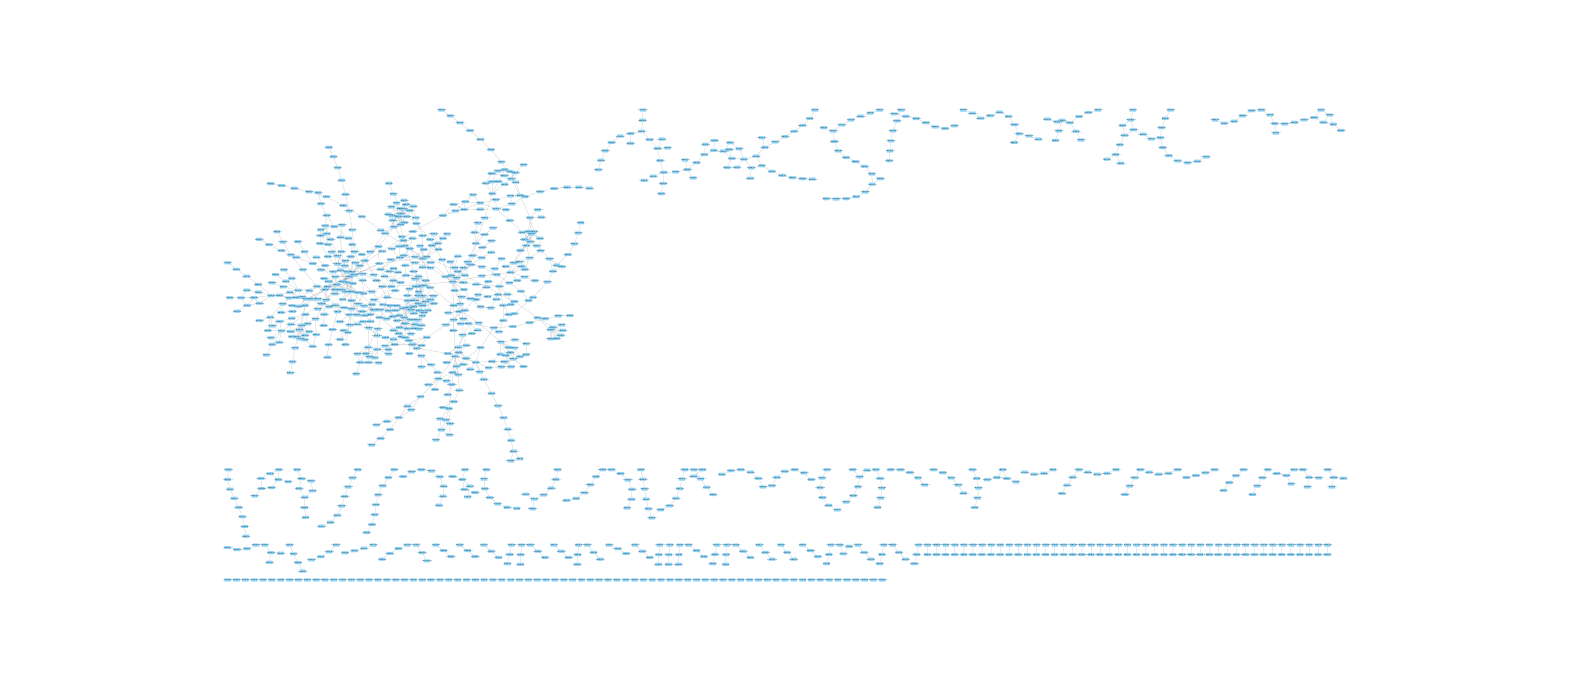

In [62]:
# display main network
p4c.notebook_export_show_image()

## Network
- Each node is a representative sequence of a homologous CDS cluster (min id:0.9 and cov:0.9)
- Each representative sequence (node) has its prokka annotation, defense system prediction and the locus_tag of all cluster members. This information can be accessed through the node table or by clicking on the node in the Cytoscape Client.
- Edges are representations of the a cluster relative topology. Replacing the locus_tags in the genomes with its the respective cluster name and extracting the position of each cluster in relation to its neighbors, it is possible to infer the topology relationships of the clusters. The edge_count parameter can be found in the edges table and displays the number of times a cluster appears next to another in a particular genome.

In [42]:
# p4c.delete_visual_style('myStyle')
# NODE_FILL_COLOR = p4c.map_visual_property('node fill color', 'name', 'd', nodes.id.values.tolist(), nodes.node_color.values.tolist())
# p4c.update_style_mapping('myStyle', NODE_FILL_COLOR)

''

In [14]:
# Create a style 
style_name = "myStyle"

# Set some default values 
# defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR' : 'node_color'}
defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR': default_color}

# Show labels on the nodes
node_labels = p4c.map_visual_property('node label', 'members_names', 'p') 

# Map node size to the count of members of a seed
node_size_map  = p4c.map_visual_property('NODE_SIZE', 'node_size', 'p')
node_shape_map = p4c.map_visual_property('NODE_SHAPE', 'node_shape', 'p')
node_color_map  = p4c.map_visual_property('node fill color', 'name', 'd', nodes['id'].values.tolist(), nodes.node_color.values.tolist())
edge_size_map  = p4c.map_visual_property('EDGE_WIDTH', 'edge_size', 'p')

node_width = p4c.map_visual_property('NODE_BORDER_WIDTH', 'border_size', 'p')



# Load style
p4c.create_visual_style(style_name, defaults, [
    node_size_map,
    node_labels,
    node_shape_map,
    edge_size_map,
    node_color_map,
    node_width,
])


p4c.set_visual_style(style_name)

p4c.set_node_border_color_mapping(**p4c.gen_node_color_map('diversity_score', p4c.palette_color_brewer_s_YlOrRd(), style_name=style_name))

# p4c.notebook_export_show_image()

''

In [26]:
wanted_nodes = [
    'OBMGFKCN_01195',
    'CAADGEIO_02721',
    'LNIMPGBG_00571',
]

p4c.select_nodes(wanted_nodes, by_col='id')

{'nodes': [431, 2039, 1385], 'edges': []}